# 데이터 읽기

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
customer = pd.read_csv('customer_join.csv')
uselog_months = pd.read_csv('use_log_months.csv')

### 이달과 1개월 전 이용 횟수 데이터

In [3]:
year_months = list(uselog_months["연월"].unique()) # 12개라는 것이 201804~201903
uselog = pd.DataFrame()
print(len(year_months))
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"] == year_months[i]] # 이달에 대한 개수
    tmp.rename(columns={"count":"count_0"}, inplace=True)
    tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-1]] # 1개월 전에 대한 개수
    del tmp_before["연월"]
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)
uselog.head()
    

12


,연월,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


In [4]:
from dateutil.relativedelta import relativedelta
exit_customer = customer.loc[customer["is_deleted"]==1]
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in range(len(exit_customer)):
    exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months=1)
exit_customer["연월"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")
uselog["연월"] = uselog["연월"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id","연월"], how="left")
print(len(uselog))
exit_uselog.head()

33851


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 결측치 제거


In [5]:
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


# 지속 회원 데이터

In [6]:
conti_customer = customer.loc[customer["is_deleted"]==0]
conti_uselog = pd.merge(uselog, conti_customer, on=["customer_id"], how="left")
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=["name"]) # name칼럼의 결측치 제거, 타뢰회원제거
print(len(conti_uselog))

33851
27422


### 데이터 섞고 중복 제거

In [7]:
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True) # 데이터 섞기 sample = 무작위로 몇개 나오기 frac = 추출할 비율
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id") # customer_id 중복값 처리 duplicates = 중복값 확인
print(len(conti_uselog))
conti_uselog.head()

2842


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201902,OA067269,8,6.0,XXXXX,C01,M,2018-03-01,NaN,CA1,...,종일,10500.0,일반,7.166667,7.5,10.0,5.0,1.0,2019-04-30,13.0
1,201806,AS942939,8,7.0,XXXXX,C02,F,2016-12-01,NaN,CA1,...,주간,7500.0,일반,5.666667,5.0,8.0,4.0,1.0,2019-04-30,28.0
2,201902,HI525283,5,4.0,XXXXXX,C03,F,2015-07-01,NaN,CA1,...,야간,6000.0,일반,4.833333,5.0,6.0,4.0,1.0,2019-04-30,45.0
3,201812,HI057067,7,8.0,XXXXXX,C01,F,2018-08-01,NaN,CA1,...,종일,10500.0,일반,8.000000,8.0,10.0,7.0,1.0,2019-04-30,8.0
4,201810,HI216184,4,3.0,XXXX,C01,M,2015-06-01,NaN,CA1,...,종일,10500.0,일반,4.000000,4.0,7.0,2.0,1.0,2019-04-30,46.0


### 지속 회원 데이터와 탈퇴 회원 데이터 세로 결합

In [8]:
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data.head()

3946


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201902,OA067269,8,6.0,XXXXX,C01,M,2018-03-01,NaT,CA1,...,10500.0,일반,7.166667,7.5,10.0,5.0,1.0,2019-04-30,13.0,NaN
1,201806,AS942939,8,7.0,XXXXX,C02,F,2016-12-01,NaT,CA1,...,7500.0,일반,5.666667,5.0,8.0,4.0,1.0,2019-04-30,28.0,NaN
2,201902,HI525283,5,4.0,XXXXXX,C03,F,2015-07-01,NaT,CA1,...,6000.0,일반,4.833333,5.0,6.0,4.0,1.0,2019-04-30,45.0,NaN
3,201812,HI057067,7,8.0,XXXXXX,C01,F,2018-08-01,NaT,CA1,...,10500.0,일반,8.000000,8.0,10.0,7.0,1.0,2019-04-30,8.0,NaN
4,201810,HI216184,4,3.0,XXXX,C01,M,2015-06-01,NaT,CA1,...,10500.0,일반,4.000000,4.0,7.0,2.0,1.0,2019-04-30,46.0,NaN


### 예측할 달의 재적 기간

In [9]:
predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = int(delta.years*12 + delta.months)
predict_data.head()

,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201902,OA067269,8,6.0,XXXXX,C01,M,2018-03-01,NaT,CA1,...,7.166667,7.5,10.0,5.0,1.0,2019-04-30,13.0,NaN,11,2019-02-01
1,201806,AS942939,8,7.0,XXXXX,C02,F,2016-12-01,NaT,CA1,...,5.666667,5.0,8.0,4.0,1.0,2019-04-30,28.0,NaN,18,2018-06-01
2,201902,HI525283,5,4.0,XXXXXX,C03,F,2015-07-01,NaT,CA1,...,4.833333,5.0,6.0,4.0,1.0,2019-04-30,45.0,NaN,43,2019-02-01
3,201812,HI057067,7,8.0,XXXXXX,C01,F,2018-08-01,NaT,CA1,...,8.000000,8.0,10.0,7.0,1.0,2019-04-30,8.0,NaN,4,2018-12-01
4,201810,HI216184,4,3.0,XXXX,C01,M,2015-06-01,NaT,CA1,...,4.000000,4.0,7.0,2.0,1.0,2019-04-30,46.0,NaN,40,2018-10-01


### 결측치 제거

In [10]:
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1               273
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [11]:
predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2621
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2621
period                  0
now_date                0
dtype: int64

In [12]:
target_col = ["campaign_name","class_name","gender","count_1","routine_flg","period","is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,일반,종일,M,6.0,1.0,11,0.0
1,일반,주간,F,7.0,1.0,18,0.0
2,일반,야간,F,4.0,1.0,43,0.0
3,일반,종일,F,8.0,1.0,4,0.0
4,일반,종일,M,3.0,1.0,40,0.0


### 더미 변수 쓰는 이유 : object가 str인 경우 수치형으로 바꾸면 관계성이 생김 ex월 : 0, 화:1... 1+2=3이 성립되게 되므로 더미함수로 가변수화 시켜 관계성을 없게
### 형식이 다른 경우 ex:man,name...등을 처리하기 위해


In [13]:
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_일반,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_야간,class_name_종일,class_name_주간,gender_F,gender_M
0,6.0,1.0,11,0.0,1,0,0,0,1,0,0,1
1,7.0,1.0,18,0.0,1,0,0,0,0,1,1,0
2,4.0,1.0,43,0.0,1,0,0,1,0,0,1,0
3,8.0,1.0,4,0.0,1,0,0,0,1,0,1,0
4,3.0,1.0,40,0.0,1,0,0,0,1,0,0,1


In [14]:
del predict_data["campaign_name_일반"]
del predict_data["class_name_야간"]
del predict_data["gender_M"]
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_종일,class_name_주간,gender_F
0,6.0,1.0,11,0.0,0,0,1,0,0
1,7.0,1.0,18,0.0,0,0,0,1,1
2,4.0,1.0,43,0.0,0,0,0,0,1
3,8.0,1.0,4,0.0,0,0,1,0,1
4,3.0,1.0,40,0.0,0,0,1,0,0


### 의사결정 트리를 사용하여 탈퇴 예측모델 구축

In [15]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

exit = predict_data.loc[predict_data["is_deleted"]==1]
confi = predict_data.loc[predict_data["is_deleted"]==0].sample(len(exit)) # 유지 데이터에서 임의로 1104건을 추출 비율 50:50

X = pd.concat([exit, confi], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)
# 1 = 탈퇴 , 0 = 유지

[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.

In [16]:
results_test = pd.DataFrame({"y_test":y_test, "y_pred":y_test_pred})
results_test.head()

,y_test,y_pred
1736,0.0,0.0
623,1.0,1.0
1525,0.0,0.0
431,1.0,0.0
1140,0.0,0.0


### 예측 모델 평가 후 모델 튜닝

In [17]:
correct = len(results_test.loc[results_test["y_test"]==results_test["y_pred"]])
data_count = len(results_test)
score_test = correct / data_count
print(score_test)

0.8897338403041825


In [18]:
print(model.score(X_test,y_test))
print(model.score(X_train, y_train))

0.8897338403041825
0.9778200253485425


In [19]:
X = pd.concat([exit, confi], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

model = DecisionTreeClassifier(random_state=0, max_depth=5) # 트리으 깊이 얕게
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.9068441064638784
0.9296577946768061


### 모델에 기여하는 변수

In [20]:
importance = pd.DataFrame({"feature_names": X.columns, "coefficient": model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.348027
1,routine_flg,0.121798
2,period,0.528149
3,campaign_name_입회비무료,0.000000
4,campaign_name_입회비반액할인,0.001265
5,class_name_종일,0.000000
6,class_name_주간,0.000153
7,gender_F,0.000608


### 회원 탈퇴 예측


In [21]:
count_1 = 3
routing_flg = 1
period = 10
campaign_name = "입회비무료"
class_name = "종일"
gender = "M"

In [22]:
if campaign_name == "입회비반값할인":
    campaign_name_list = [1, 0]
elif campaign_name == "입회비무료":
    campaign_name_list = [0, 1]
elif campaign_name == "일반":
    campaign_name_list = [0, 0]
if class_name == "종일":
    class_name_list = [1, 0]
elif class_name == "주간":
    class_name_list = [0, 1]
elif class_name == "야간":
    class_name_list = [0, 0]
if gender == "F":
    gender_list = [1]
elif gender == "M":
    gender_list = [0]
input_data = [count_1, routing_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)
print(model.predict([input_data]))
print(model.predict_proba([input_data]))



[1.]
[[0. 1.]]


In [23]:
#의사결정나무는 과적합 방지위해 트리 깊이를 얕게하면 모델 단순화

#설명, 종속 변수 설정
X = pd.concat([exit, confi], ignore_index = True) #인텍스 초기화
y = X['is_deleted']
del X['is_deleted']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

#모델 구축
model = DecisionTreeClassifier(random_state = 0, max_depth = 5) #파라미터 변경 5층까지만
model.fit(X_train, y_train)
#예측값
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9271229404309252
0.9239543726235742


# 모델에 기여하는 변수

In [24]:
imp = pd.DataFrame({'feature': X.columns, 'coefficient':model.feature_importances_})
imp = imp.sort_values(by = 'coefficient', ascending=False)
imp

,feature,coefficient
2,period,0.526701
0,count_1,0.338324
1,routine_flg,0.132864
4,campaign_name_입회비반액할인,0.002005
7,gender_F,0.000085
6,class_name_주간,0.000021
3,campaign_name_입회비무료,0.000000
5,class_name_종일,0.000000


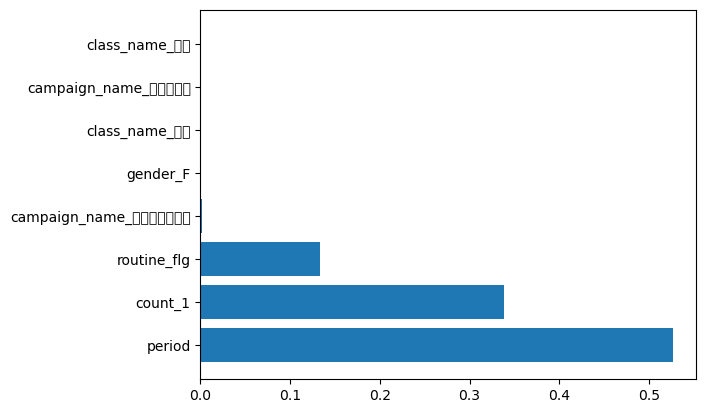

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.barh(imp['feature'], imp['coefficient'])
plt.show()

In [27]:
input_data = [count_1, routing_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

input_data

[3, 1, 10, 0, 1, 1, 0, 0]

In [28]:
print(model.predict([input_data]))

[1.]


In [29]:
print(model.predict_proba([input_data]))

[[0. 1.]]
